## Time Series Analysis - Air Quality 
Time: (2001 - 2018) Madrid

Using the Seaborn Package for plotting and SciKit-Learn for the modelling

In [1]:
%%capture
!pip3 install seaborn 
!pip3 install scikit-learn

importing all package which I will be using in this program

In [2]:
import pandas as pandas
import glob
import os
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model
import matplotlib.pyplot as matplotlib
import seaborn as seaborn
from sktime.utils.plotting import plot_series
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.metrics import r2_score
from statsmodels.tsa.stattools import adfuller
import numpy as numpy
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

using the plobal packages to read the csv data. The gob (global) package finds patterns within file types - it is a Unix style pathname pattern matching expansion. 

In [3]:
path = '/home/adam/Documents/Python/SciPython/Kaggle/Multivariate-TimeSeries-Analysis/csvs_per_year'
extension = 'csv'
os.chdir(path)
result = glob.glob('*.{}'.format(extension))
result = sorted(result)
print(result)

['madrid_2001.csv', 'madrid_2002.csv', 'madrid_2003.csv', 'madrid_2004.csv', 'madrid_2005.csv', 'madrid_2006.csv', 'madrid_2007.csv', 'madrid_2008.csv', 'madrid_2009.csv', 'madrid_2010.csv', 'madrid_2011.csv', 'madrid_2012.csv', 'madrid_2013.csv', 'madrid_2014.csv', 'madrid_2015.csv', 'madrid_2016.csv', 'madrid_2017.csv', 'madrid_2018.csv']


reading the data with pandas and creating a dataframe. 

In [4]:
dataframe = pandas.DataFrame()
for file in result:
    matchCSV = pandas.read_csv(file)
    dataframe = dataframe.append(matchCSV)
# change date into datetime format
dataframe['date'] = pandas.to_datetime(dataframe.date, infer_datetime_format = True)
dataframe.head()

,date,BEN,CO,EBE,MXY,NMHC,NO_2,NOx,OXY,O_3,PM10,PXY,SO_2,TCH,TOL,station,PM25,NO,CH4
0,2001-08-01 01:00:00,NaN,0.37,NaN,NaN,NaN,58.400002,87.150002,NaN,34.529999,105.000000,NaN,6.34,NaN,NaN,28079001,NaN,NaN,NaN
1,2001-08-01 01:00:00,1.5,0.34,1.49,4.1,0.07,56.250000,75.169998,2.11,42.160000,100.599998,1.73,8.11,1.24,10.82,28079035,NaN,NaN,NaN
2,2001-08-01 01:00:00,NaN,0.28,NaN,NaN,NaN,50.660000,61.380001,NaN,46.310001,100.099998,NaN,7.85,NaN,NaN,28079003,NaN,NaN,NaN
3,2001-08-01 01:00:00,NaN,0.47,NaN,NaN,NaN,69.790001,73.449997,NaN,40.650002,69.779999,NaN,6.46,NaN,NaN,28079004,NaN,NaN,NaN
4,2001-08-01 01:00:00,NaN,0.39,NaN,NaN,NaN,22.830000,24.799999,NaN,66.309998,75.180000,NaN,8.80,NaN,NaN,28079039,NaN,NaN,NaN


### PreProcessing
Changing into a well established unit of meature (micro grams pr metre cubed) $$mgm ^3  \rightarrow μmg^3$$
$$μmg^3 = \frac{mgm ^ 3}{1000}$$
so, we need to divide each of the offending elements - Cobalt (CO), Technetium (TCH) and Methan (CH4). Adapting the dataframe.

In [5]:
dataframe['CO' ] = dataframe['CO' ] / 1000
dataframe['TCH'] = dataframe['TCH'] / 1000
dataframe['CH4'] = dataframe['CH4'] / 1000
# check for null values 
dataframe.isnull().sum()

date             0
BEN        2766540
CO         1157212
EBE        2806500
MXY        3492809
NMHC       2722912
NO_2         21174
NOx        1431949
OXY        3492529
O_3         816492
PM10        946969
PXY        3492640
SO_2       1032264
TCH        2721783
TOL        2769295
station          0
PM25       2991800
NO         2275827
CH4        3793374
dtype: int64

In [6]:
# looking at the stations this data came from and see if we can match the stations up
# This is because of NULL values in the dataset. You may not want to process these
# straight away as it could lead to wrong assumptions and affect how realistic the output 
# from the model is. 

# Opening and viewing the stations dataset. 

stationDataframe = pandas.read_csv('/home/adam/Documents/Python/SciPython/Kaggle/Multivariate-TimeSeries-Analysis/stations.csv')
display(stationDataframe)

,id,name,address,lon,lat,elevation
0,28079004,Pza. de España,Plaza de España,-3.712247,40.423853,635
1,28079008,Escuelas Aguirre,Entre C/ Alcalá y C/ O’ Donell,-3.682319,40.421564,670
2,28079011,Avda. Ramón y Cajal,Avda. Ramón y Cajal esq. C/ Príncipe de Vergara,-3.677356,40.451475,708
3,28079016,Arturo Soria,C/ Arturo Soria esq. C/ Vizconde de los Asilos,-3.639233,40.440047,693
4,28079017,Villaverde,C/. Juan Peñalver,-3.713322,40.347139,604
5,28079018,Farolillo,Calle Farolillo - C/Ervigio,-3.731853,40.394781,630
6,28079024,Casa de Campo,Casa de Campo (Terminal del Teleférico),-3.747347,40.419356,642
7,28079027,Barajas Pueblo,"C/. Júpiter, 21 (Barajas)",-3.580031,40.476928,621
8,28079035,Pza. del Carmen,Plaza del Carmen esq. Tres Cruces.,-3.703172,40.419208,659
9,28079036,Moratalaz,Avd. Moratalaz esq. Camino de los Vinateros,-3.645306,40.407947,685


From this dataset we should take the ID column. Then match this ID with the dataset above containing the pollutant measurements. 

This will be done via grouping. Therefore, we can focus on subpopulations charaterised by their corresponding identification number. This should improve the accuracy and efficieny of the estimation. 

However, one should note that the precision of the graphs which are produced from the grouped data ONLY give a view of the subpopulation not the population as a whole. 

We will create a new dataframe. This dataframe will group each station to it's meaurments.

In [7]:
dataframeGroupStations = dataframe.groupby('station')
# checking the stations are grouped and then add a dates column. 
Pza_de_Espana = dataframeGroupStations.get_group(28079004)
Pza_de_Espana.index = Pza_de_Espana.date
Pza_de_Espana = Pza_de_Espana.drop(['date'], axis = 1)
Pza_de_Espana.shape
display(Pza_de_Espana)

,BEN,CO,EBE,MXY,NMHC,NO_2,NOx,OXY,O_3,PM10,PXY,SO_2,TCH,TOL,station,PM25,NO,CH4
date,,,,,,,,,,,,,,,,,,
2001-08-01 01:00:00,NaN,0.00047,NaN,NaN,NaN,69.790001,73.449997,NaN,40.650002,69.779999,NaN,6.46,NaN,NaN,28079004,NaN,NaN,NaN
2001-08-01 02:00:00,NaN,0.00033,NaN,NaN,NaN,64.110001,66.849998,NaN,45.230000,47.509998,NaN,6.41,NaN,NaN,28079004,NaN,NaN,NaN
2001-08-01 03:00:00,NaN,0.00027,NaN,NaN,NaN,60.349998,62.610001,NaN,49.610001,42.110001,NaN,5.88,NaN,NaN,28079004,NaN,NaN,NaN
2001-08-01 04:00:00,NaN,0.00021,NaN,NaN,NaN,48.689999,49.959999,NaN,61.830002,27.250000,NaN,5.29,NaN,NaN,28079004,NaN,NaN,NaN
2001-08-01 05:00:00,NaN,0.00018,NaN,NaN,NaN,46.189999,47.320000,NaN,62.889999,31.520000,NaN,5.31,NaN,NaN,28079004,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-31 20:00:00,NaN,0.00130,NaN,NaN,NaN,118.000000,432.000000,NaN,NaN,NaN,NaN,10.00,NaN,NaN,28079004,NaN,205.0,NaN
2018-01-31 21:00:00,NaN,0.00130,NaN,NaN,NaN,127.000000,475.000000,NaN,NaN,NaN,NaN,12.00,NaN,NaN,28079004,NaN,227.0,NaN
2018-01-31 22:00:00,NaN,0.00140,NaN,NaN,NaN,126.000000,512.000000,NaN,NaN,NaN,NaN,13.00,NaN,NaN,28079004,NaN,251.0,NaN


we can that this statioo did not measure some pollutants but measured others. I will be making an assumption that various stations measured elements that others did not measure as much. This could be for various reasons. 

Acounting for the missing data. We can gain a proportion of all measurements. 
The total number of measurements is the number of rows. In this case it is 151,776. 

Therefore, Let $x$ be the number of NULL values. Let $T$ be the total number of measurments. 

$$NULL(D(x)) = \frac{100}{T} \sum_{n = 1}^{T}(x)$$

where $D(x)$ is the dataframe in this case

Then this summation will produce a table for each element.

<AxesSubplot:ylabel='date'>

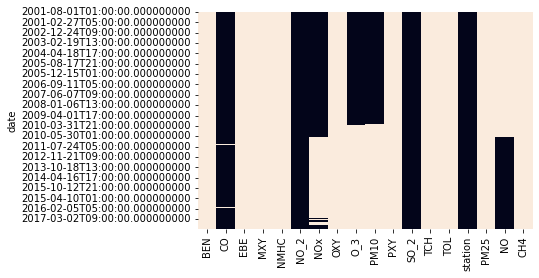

In [8]:
Pza_de_Espana.isnull().sum()/151776 * 100
seaborn.heatmap(Pza_de_Espana.isnull(), cbar=False)

We can see that most of the dataframe is infact empty and therefore we will need to remove most of these columns. 

Based on the assumption above, to avoid a bias in measurment we should drop the measurments which would cause a bias. That is, the measurments with the biggest proportion of NULL values. This would be: {BEN, EBE, MXY, NMHC, OXY, PXY, TCH, TOL, PM25, CH4, THC}

In [9]:
Pza_de_Espana = Pza_de_Espana.drop(['BEN', 
                                    'EBE', 
                                    'MXY', 
                                    'NMHC', 
                                    'OXY', 
                                    'PXY', 
                                    'TCH', 
                                    'TOL', 
                                    'PM25', 
                                    'CH4'], axis = 1)

In [10]:
Pza_de_Espana.skew()

CO         3.978275
NO_2       1.112047
NOx        2.490633
O_3        0.859097
PM10       1.961725
SO_2       3.340970
station    0.000000
NO         3.142522
dtype: float64

<AxesSubplot:xlabel='CO', ylabel='Count'>

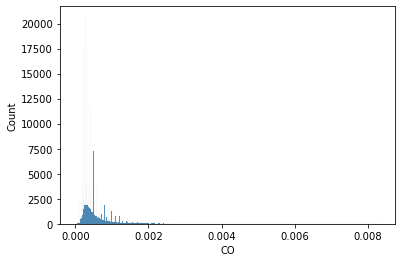

In [11]:
seaborn.histplot(data=Pza_de_Espana['CO'])

A general concensus on when to use mean/median for imputation. No more than 5% of the variables contain missing data. So with CO we can impute with the mean. All of the data is skewed with Carbon Monoxide (CO) and Nitrogen Oxide (NO) being highly skewed datasets. This may effects the accuracy of the model because with the highly skewed datasets the tail can act as an outlier. When an outlier is involved in the dataset it can affect the model since some tests may rely on the dataset following a gaussian distribution. For fitting regression models the model the data is assumed to follow a gaussian distibution centered at 0. Therefore if the data is not actually gaussian then the model output will be affected for regions where the distrbution is lower. For out model it will be better at prediting lower levels of CO concentration than higher levels. 

,CO,NO_2,NOx,O_3,PM10,SO_2,station,NO
date,,,,,,,,
2001-08-01 01:00:00,0.00047,69.790001,73.449997,40.650002,69.779999,6.46,28079004,13.0
2001-08-01 02:00:00,0.00033,64.110001,66.849998,45.230000,47.509998,6.41,28079004,13.0
2001-08-01 03:00:00,0.00027,60.349998,62.610001,49.610001,42.110001,5.88,28079004,13.0
2001-08-01 04:00:00,0.00021,48.689999,49.959999,61.830002,27.250000,5.29,28079004,13.0
2001-08-01 05:00:00,0.00018,46.189999,47.320000,62.889999,31.520000,5.31,28079004,13.0
...,...,...,...,...,...,...,...,...
2018-01-31 20:00:00,0.00130,118.000000,432.000000,29.090000,21.760000,10.00,28079004,205.0
2018-01-31 21:00:00,0.00130,127.000000,475.000000,29.090000,21.760000,12.00,28079004,227.0
2018-01-31 22:00:00,0.00140,126.000000,512.000000,29.090000,21.760000,13.00,28079004,251.0


<AxesSubplot:ylabel='date'>

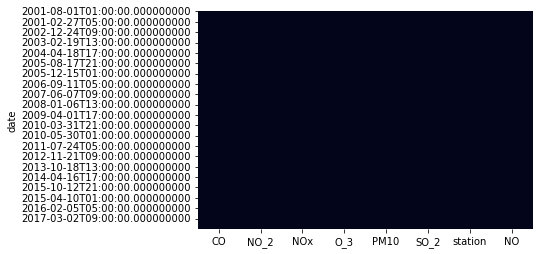

In [12]:
Pza_de_Espana['O_3'].fillna(Pza_de_Espana['O_3'].median(), inplace = True)
Pza_de_Espana['CO'].fillna(Pza_de_Espana['CO'].median(), inplace = True)
Pza_de_Espana['NOx'].fillna(Pza_de_Espana['NOx'].median(), inplace = True)
Pza_de_Espana['NO_2'].fillna(Pza_de_Espana['NO_2'].median(), inplace = True)
Pza_de_Espana['PM10'].fillna(Pza_de_Espana['PM10'].median(), inplace = True)
Pza_de_Espana['SO_2'].fillna(Pza_de_Espana['SO_2'].median(), inplace = True)
Pza_de_Espana['NO'].fillna(Pza_de_Espana['NO'].median(), inplace = True)
display(Pza_de_Espana)
seaborn.heatmap(Pza_de_Espana.isnull(), cbar=False)

Now all of the empty columns have been removed and we have replaced the remaining missing data with the mean and medians of the columns

For dealing with the missing data we can use a frequentist interpretation of Ridge Regression known as Baysian Ridge Regression and then use the Multivariate Imputation By Chaine Equations which imputes missing data by looking at other columns in the data and infering the value based upon those other values. 

A derivation of BRR will be provided which explains the connection between classical ridge regression and baysian regression. 

In [13]:
MICEimputation = IterativeImputer(estimator = linear_model.BayesianRidge(), n_nearest_features = None, imputation_order = 'ascending')
imputedData = pandas.DataFrame(MICEimputation.fit_transform(Pza_de_Espana),columns = Pza_de_Espana.columns, index = Pza_de_Espana.index)

Performing a Hypothesis Test on the data, to check where it is stationary. 

I will be using the Augmented Dickey-Fuller test. We will test the null hypothesis $H_{0}$ that there exists a unit-root within the time series data. A unit root is a charateristic of a time series that makes it non-stationary.

The alternative hypothesis $H_{1}$ which there is no trend.

The ADF statistic will be negative, the more the statistic implies that there exists more evidence to reject the null hypothesis.

A p-value of $p < 0.05$ will indicate a rejection of $H_{0}$ in favour of $H_{1}$

In definition: The Augmented Dickey-Fuller test can be used to test for unit root in the prescence of serial correlation.  

Given $$Y_{t} = \alpha Y_{t-1} + \beta X_{e} + \epsilon $$

The DF test will test $H_{0}: \alpha = 1$ in the following version of the unit-root equation $$y_{t} = c + \beta t + \alpha y_{t-1} + \phi \Delta Y_{t-1} + e_{t}$$

The ADF test expands upon the DF test to include a higher order regression in the model. This follows: $$y_{t} = c + \beta t + \alpha y_{t-1} + \sum_{k} ^{p}  \phi_{k} \Delta Y_{t-k} + e_{t}$$




In [14]:
imputedDataResample = imputedData.resample('M').sum() # resampling on monthly basis 
ADFtest = adfuller(imputedDataResample['CO'])
print('\nStatistical Unit Root Test\n')
print('DF Statistic: ', ADFtest[0])
print('p-value: ', ADFtest[1])
print('number of lags: ', ADFtest[2])
print('Number of Observations: ', ADFtest[3])
for key, value in ADFtest[4].items():
    print(f' critical value {key} | {value}')


Statistical Unit Root Test

DF Statistic:  -3.5492138141761136
p-value:  0.006809560626421673
number of lags:  13
Number of Observations:  195
 critical value 1% | -3.464337030867007
 critical value 5% | -2.876478799035722
 critical value 10% | -2.574733103221565


Here we can see a strong negative correlation. We should conclude there is no trend in this time series data. Here $p = 0.006 < 0.05$ therefore $H_{0}$ should be rejected. The strong negative correlation of $-3.54$ should be interpreted as evidence to reject the null too. Therefore $\alpha \neq 1$ and there is no unit root and hence the series in stationary

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:xlabel='Date by Month', ylabel='Carbon Monoxide Level (μmg-3)'>)

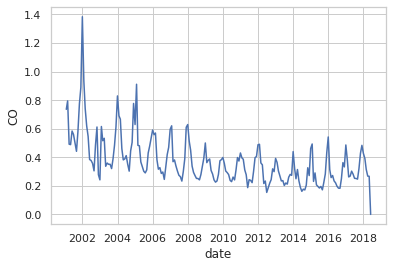

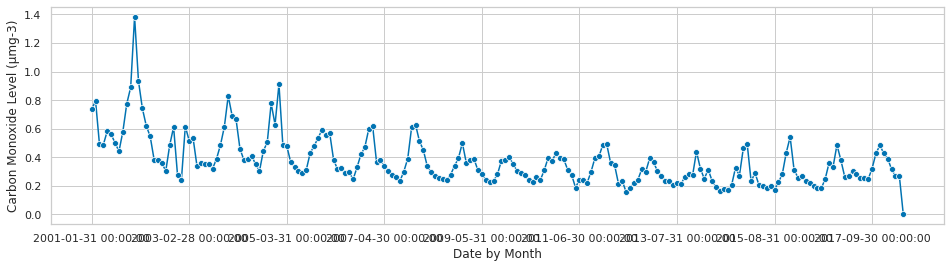

In [15]:
# printing the monthly trend of carbon monoxide 
seaborn.set_theme(style = 'whitegrid')
seaborn.lineplot(data = imputedDataResample, x = imputedDataResample.index, y = 'CO' )
plot_series(imputedDataResample['CO'], 
            x_label = 'Date by Month', 
            y_label = 'Carbon Monoxide Level (μmg-3)') # for carbon monoxide. 

Now we will take a deeper look on the levels of carbon monoxide and have a look, through the correlation matrix, which elements interfear with the levels of carbon monoxide in the air. For this we will use a heatmap. 

A correlation matrix is a symmetric positive semidefinite matrix with unit diagonal. Therefore, therefore the diagnoal is 1, and the eigenvalues of the matrix are all positive. 

Let $$R=\left(\begin{array}{cccc}
1 & r_{12} & \cdots & r_{1n}\\
r_{21} & 1 & \cdots & r_{2n}\\
\vdots & \vdots & \ddots & \vdots\\
r_{n1} & r_{n2} & r_{n3} & 1
\end{array}\right)$$
be the correlation matrix for the data above. Where: $$r_{jk}=\frac{\sum_{i=1}^{n}\left(x_{ij}-\overline{x_{j}}\right)\left(x_{ik}-\overline{x_{k}}\right)}{\sqrt{\sum_{i=1}^{n}\left(x_{ij}-\bar{x_{j}}\right)^{2}}\sqrt{\sum_{i=1}^{n}\left(x_{ik}-\bar{x_{k}}\right)^{2}}}$$

which can be visulaised as a heatmap. Seaborn can do this directly.

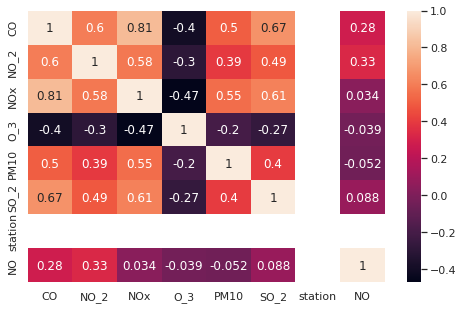

In [16]:
def plotHeatmap():
    # heat map for the data 
    fig, ax = matplotlib.subplots(figsize = (8, 5))
    seaborn.heatmap(imputedData.corr(), annot = True, ax = ax)

plotHeatmap()

we can see that NO does not have much of an influence on the level of carbon monoxide in the air as the correlation is low. At -0.28, therefore we can drop it

In [17]:
imputedData = imputedData.drop(['NO', 'station'], axis = 1)
display(imputedData)

,CO,NO_2,NOx,O_3,PM10,SO_2
date,,,,,,
2001-08-01 01:00:00,0.00047,69.790001,73.449997,40.650002,69.779999,6.46
2001-08-01 02:00:00,0.00033,64.110001,66.849998,45.230000,47.509998,6.41
2001-08-01 03:00:00,0.00027,60.349998,62.610001,49.610001,42.110001,5.88
2001-08-01 04:00:00,0.00021,48.689999,49.959999,61.830002,27.250000,5.29
2001-08-01 05:00:00,0.00018,46.189999,47.320000,62.889999,31.520000,5.31
...,...,...,...,...,...,...
2018-01-31 20:00:00,0.00130,118.000000,432.000000,29.090000,21.760000,10.00
2018-01-31 21:00:00,0.00130,127.000000,475.000000,29.090000,21.760000,12.00
2018-01-31 22:00:00,0.00140,126.000000,512.000000,29.090000,21.760000,13.00


Now we need to add a lag variable to create a disrbuted lag model. This is a odel for time series data for which a ression equation is used to predict current variables based upon past observations, to update a dependant variable. 

The dependant variable is updated from both current values of explanatory variables and the lagged variables. The lagged variables are previous data of the current explanatory variable. 
Therefore, we should assume that the structure of the equation is of the form $$y_{t}=a+w_{0}x_{t} + \sum_{k}^{N} w_{k}x_{t-k} + \epsilon$$ where $y_{t}$ is the value at a time period $t$ and the dependent variable, $w_{t}$ is some lag weight to be estimated and $x$ is the explantory variable and $\epsilon$ is an error term. 

In [ ]:
mainDataframe = pandas.DataFrame()
for tic in range(12, 0, -1):
    mainDataframe['t-' + str(tic)] = imputedData.CO.shift(tic)
laggedData = pandas.concat([imputedData, mainDataframe], axis = 1)
laggedData.dropna(inplace = True)
mainDataframe.reset_index(drop = True)
train = laggedData.loc['2001-08-01' : '2017-02-01'] # six month periods
test = laggedData.loc['2017-03-01' : '2018-02-01']
print(train.columns)
x_test = test.loc[:, test.columns != 'CO'] # anything but dependant variable
y_test = test['CO'] #DV
x_train = train.loc[:, train.columns != 'CO']
y_train = train['CO']
Regression = RandomForestRegressor(n_estimators = 10, 
                                   random_state=42,
                                   warm_start = True, 
                                   verbose = 100, 
                                   n_jobs = 100) #standard values
#batch processing 
for i in range(10): # for adding 10 more trees each time, 10 + 10 + ... + 10 = 100
  dataRFE = RFE(estimator=Regression, n_features_to_select=6, verbose = 100)
  DataFit = dataRFE.fit(x_train, y_train)
  Regression.n_estimators += 10
Prediction = DataFit.predict(x_test)

# This should speed the process up by splitting the fitting into smaller batch sizes
# Each time it will process one feature at a time. 17 times.
# The warm start parameter should be used to batch process the data. Since we are reusing 
# the trees and adding more to the ensemble should increase the speed by 10x. 

Now I will be computing the Mean Squared Error to evaluate the accuracy of the predicted data against the actual values. So, we take the training data and the test data then compute MSE. 

$$MSE=\frac{1}{N}\sum_{k=1}^{N}\left(y_{k}-\hat{y_{k}}\right)^2$$

we will be using another form. By breaking the sum up into parts we can easily implement it. 

$$MSE\%=100-\frac{100}{N}\sum_{k=1}^{N}\left|\left(y_{k}-\hat{y_{k}}\right)\right|$$

In machine learning MSE is known as a loss function. We take the difference of the models predictions and the ground truth, then square it and take an average. This will measure the quality of the models prediction. The function maps arbirary inputs to a sample of values of some random variable. 

So from the model we created a vector of $n$ predictions which was generated froma  sample of $n$ data points on all the variables/features. $y_{k} \in Y$ where $Y$ is a vector of observed vaues of the value being predicted and $\hat{y_{k}} \in \hat{Y}$ being the predicted values. The intuition behind MSE is that the function will tell you how close a regression line is to a set of true points. It does this by taking the distances of the points to the regression line. The squaring will remove any negative values. The distances will be the errors in the measurement. This just quantified the errors. 

In [ ]:
# calculating the loss

TrueValues = numpy.array(y_test) # vector containing the true values
SumValues = numpy.sum(TrueValues) # sum of first portion 
Calculation = numpy.sum(numpy.abs((TrueValues - Prediction)))
Calculation = Calculation/SumValues
Calculation = 100 - (Calculation * 100)
print('Accuracy: ', Calculation, '%')



Accuracy:  80.51737027596806 %


,0
date,
2017-06-01 01:00:00,0.000241
2017-06-01 02:00:00,0.000267
2017-06-01 03:00:00,0.000273
2017-06-01 04:00:00,0.000298
2017-06-01 05:00:00,0.000188
...,...
2018-01-31 20:00:00,0.001599
2018-01-31 21:00:00,0.001582
2018-01-31 22:00:00,0.001691


<AxesSubplot:xlabel='date', ylabel='CO'>

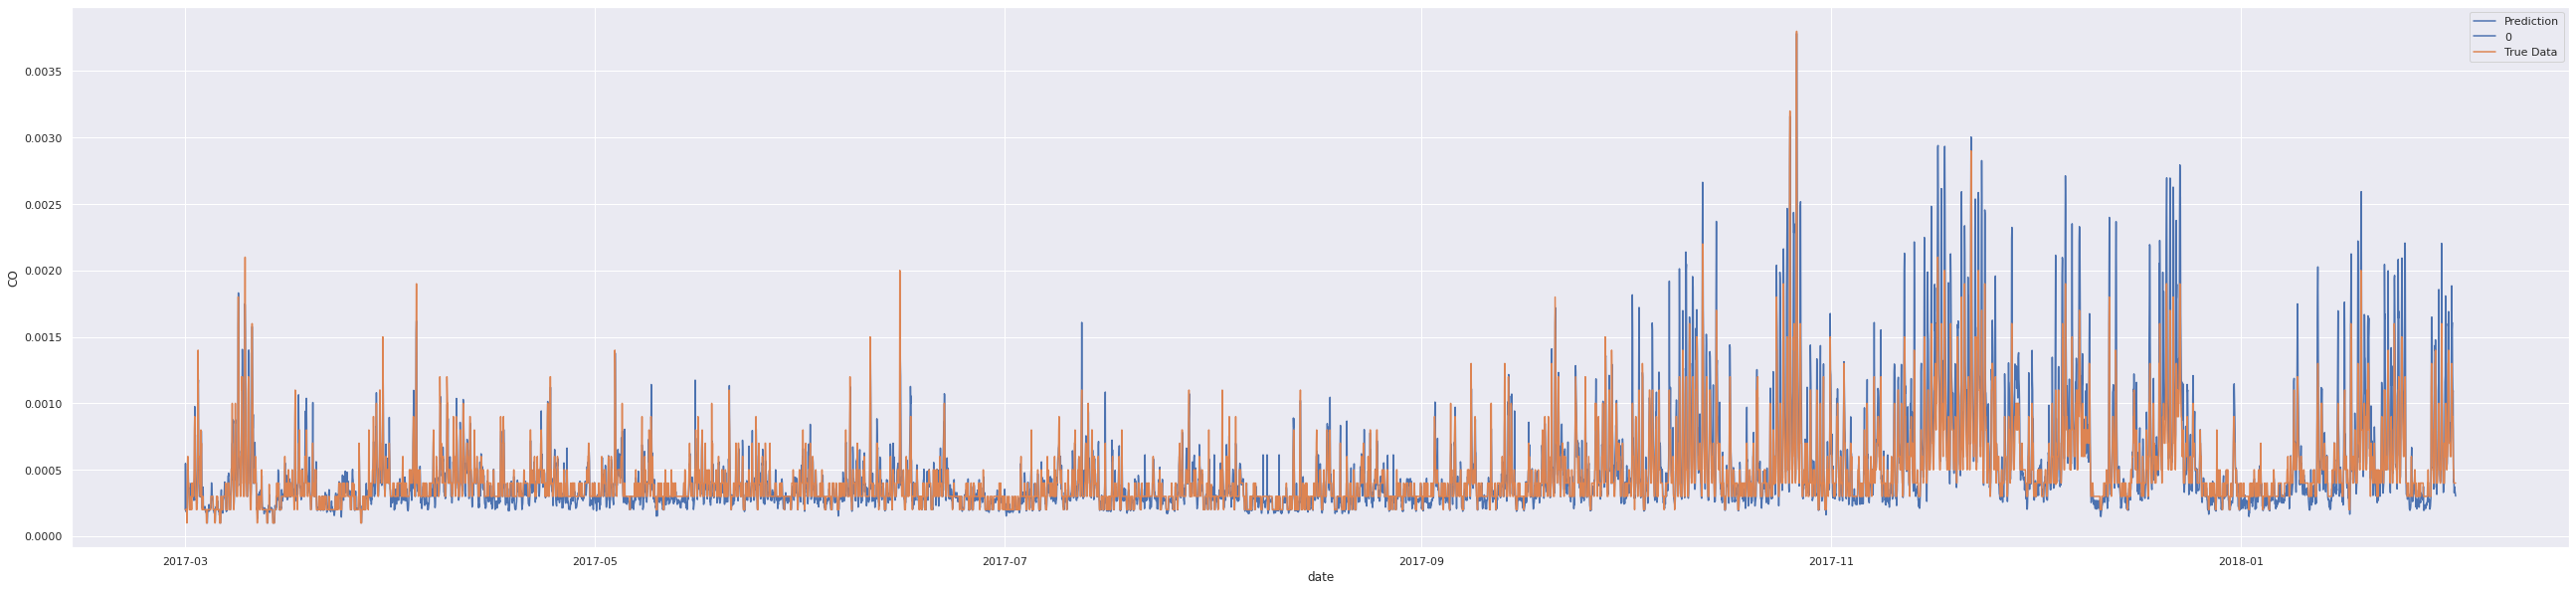

In [ ]:
from cProfile import label


dataframePrediction = pandas.DataFrame(Prediction)
dataframePrediction['date'] = y_test.index
dataframePrediction['date'] = pandas.to_datetime(dataframePrediction.date, infer_datetime_format = True)
dataframePrediction.index = dataframePrediction['date']
dataframePrediction = dataframePrediction.drop(['date'], axis = 1)
dataframePrediction.index = pandas.to_datetime(dataframePrediction.index)
display(dataframePrediction)
'''
seaborn.set(rc = {'figure.figsize':(45, 10)})
seaborn.lineplot(data = y_train)
seaborn.lineplot(data = y_test)
seaborn.lineplot(data = dataframePrediction)
'''
seaborn.set(rc = {'figure.figsize':(45, 10)})
seaborn.lineplot(data=dataframePrediction, label = 'Prediction')
#seaborn.lineplot(data=y_train)
seaborn.lineplot(data=y_test, label = 'True Data')